In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2

from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K



2024-07-26 10:39:10.975712: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-26 10:39:11.014411: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


VOC-NOTICE: GPU memory for this assignment is capped at 1024MiB


2024-07-26 10:39:13.061886: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.astype('float') / 255.
X_test = X_test.astype('float') / 255.

X_train = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))
X_test = X_test.reshape(len(X_test), np.prod(X_test.shape[1:]))
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [3]:
#params

input_dims = 784
hidden_dims = 400
latent_dims = 20
epochs = 50
batch_size = 128

In [4]:
# encoder

inputs = Input(shape=(input_dims,))
h = Dense(hidden_dims, activation='relu')(inputs)
z_mean = Dense(latent_dims)(h)
z_log_sigma = Dense(latent_dims)(h)

In [5]:
# sampling from z_mean and z_log_sigma
def sampling(args):
    z_mean, z_log_sigma = args
    eps = K.random_normal(shape=(K.shape(z_mean)[0], latent_dims), mean=0.0, stddev=1.0)
    return z_mean + eps * K.exp(z_log_sigma)

z = Lambda(sampling, output_shape=(latent_dims,))([z_mean, z_log_sigma])

In [6]:
# decoder

dh = Dense(hidden_dims, activation='relu')(z)
out = Dense(input_dims, activation='sigmoid')(dh)

vae = Model(inputs, out)
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 400)                  314000    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 20)                   8020      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 20)                   8020      ['dense[0][0]']               
                                                                                              

In [12]:
# loss funciton
xcent_loss = input_dims * binary_crossentropy(inputs, out)
kld_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)

vae_loss = K.mean(xcent_loss + kld_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [14]:
# training
vae.fit(X_train, X_train, shuffle=True, batch_size=batch_size, epochs=epochs, validation_data=(X_test, X_test))

Epoch 1/50
469/469 [==============================] - 6s 11ms/step - loss: 488.7650 - val_loss: 355.2055
Epoch 2/50
469/469 [==============================] - 5s 10ms/step - loss: 333.3523 - val_loss: 312.9297
Epoch 3/50
469/469 [==============================] - 5s 10ms/step - loss: 308.0237 - val_loss: 298.9060
Epoch 4/50
469/469 [==============================] - 5s 10ms/step - loss: 297.0723 - val_loss: 290.5792
Epoch 5/50
469/469 [==============================] - 5s 10ms/step - loss: 290.1786 - val_loss: 285.6376
Epoch 6/50
469/469 [==============================] - 5s 10ms/step - loss: 285.5367 - val_loss: 281.1079
Epoch 7/50
469/469 [==============================] - 5s 10ms/step - loss: 282.2431 - val_loss: 278.6447
Epoch 8/50
469/469 [==============================] - 5s 10ms/step - loss: 279.6324 - val_loss: 276.5444
Epoch 9/50
469/469 [==============================] - 5s 10ms/step - loss: 277.5678 - val_loss: 274.8641
Epoch 10/50
469/469 [==============================] - 

In [15]:
# predicted
X_test_pred = vae.predict(X_test)

313/313 [==============================] - 1s 2ms/step


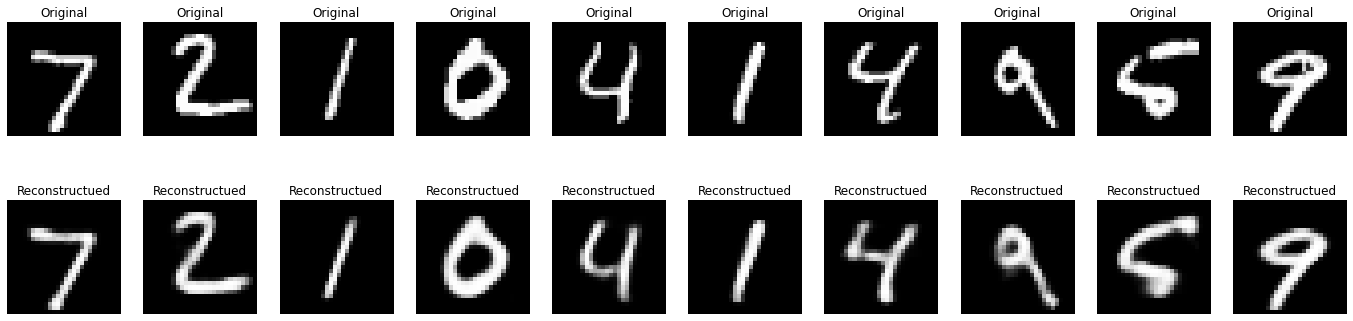

In [19]:
n = 10
fig = plt.figure(figsize=(24,6))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28,28), cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(2, n, n+i+1)
    plt.imshow(X_test_pred[i].reshape(28, 28), cmap='gray')
    plt.title('Reconstructued')
    plt.axis('off')
    
plt.show()